## Introdução

###Problema:
O produto busca atender o requisito da PensComp, organização educacional, que promove anualmente cursos online.
<br><br>
O cliente utiliza aulas online semanais e acesso a uma plataforma de aprendizagem baseada em Moodle.
<br><br>
Como o Cliente anualmente enfrenta uma evasão enorme nos alunos, ele busca um produto que seja capaz de **predizer precocemente quais estudantes estão em risco de abandono** para que a organização possa implementar intervenções direcionadas.
<br><br>
Em sua implementação final, a solução vai ser integrada ao sistema Moodle utilizada pela organização, permitindo gerar relatórios e gerar alertas específicos para a intervenção pedagógica.
<br><br>
A equipe também se dividiu para atuar da seguinte forma:
* **Introdução:** Stefano Mossi
* **Manipulação e Exploração dos Dados** Bruno Silveira e Stefano Mossi
* **Modelagem:** Rhayra Fiorentin e Rafael Noll
* **Teste do modelo final:** Alan Scheibler
* **Explicabilidade do modelo final:** Rhayra Fiorentin e Bruno Silveira
* **Exportação do modelo de produção:** Rafael Noll


### Importação dos dados de treinamento
O primeiro passo realizado foi a importação das bibliotecas utilizadas na limpeza, criação de gráficos e etc. Utilizamos o **pandas** para manipulação e visualização dos dados.

Além disso, removemos o limite de linhas que aparecem ao visualizar os dados, visto que são poucos dados manipulados.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
df = pd.read_csv('https://drive.google.com/uc?id=1e4m-tisJzxranNREG38jyPA_RxJbkrEX')


Aqui iniciamos a limpeza dos dados, tirando primeiramente os usuários que não acessaram a plataforma. Limpando isso, ocorreu uma deleção muito grande dos dados.

In [ ]:
df = df[~((df['ts_primeiro_acesso'] == 0) & (df['ts_ultimo_acesso'] == 0))]


Padronização dos nomes de cidades para visualização.

In [ ]:
df['ds_cidade_usuario'] = df['ds_cidade_usuario'].str.title()
df['ds_cidade_usuario'] = df['ds_cidade_usuario'].replace('Sao Paulo', 'São Paulo')

Tratamento de cidades que apontam como NaN (Not a Number).

In [ ]:
df['ds_cidade_usuario'] = df['ds_cidade_usuario'].fillna("NA")
df = df.fillna(0)


Aqui, adicionamos novas colunas que podem ser utilizadas para o treinamento, como a comparação do primeiro acesso com o último.

In [ ]:
df['nr_diferenca_dias'] = df['nr_dias_desde_primeiro_acesso'] - df['nr_dias_desde_ultimo_acesso']
colunas = df.columns.tolist()
colunas.insert(df.columns.get_loc('nr_dias_desde_ultimo_acesso') + 1, colunas.pop(colunas.index('nr_diferenca_dias')))
df = df[colunas]

Adiciona uma coluna que cálcula a porcentagem de questionários finalizados pela quantia de questionários iniciados (soma abandonados e finalizados), transforma em porcentagem. Além de também calcular a média de engajamento do usuário (discussões + questionários / 2).

In [ ]:
df['vl_conclusao_questionarios'] = df['nr_questionarios_finalizados'] / (df['nr_questionarios_abandonados'] + df['nr_questionarios_finalizados'])  * 100
df['vl_media_engajamento'] = (df['nr_engajamento_discussao'] + df['nr_engajamento_questionario']) / 2
df['vl_conclusao_questionarios'] = df['vl_conclusao_questionarios'].fillna(0)




## Visualizações


Visualização da quantidade de alunos por cidade no curso.

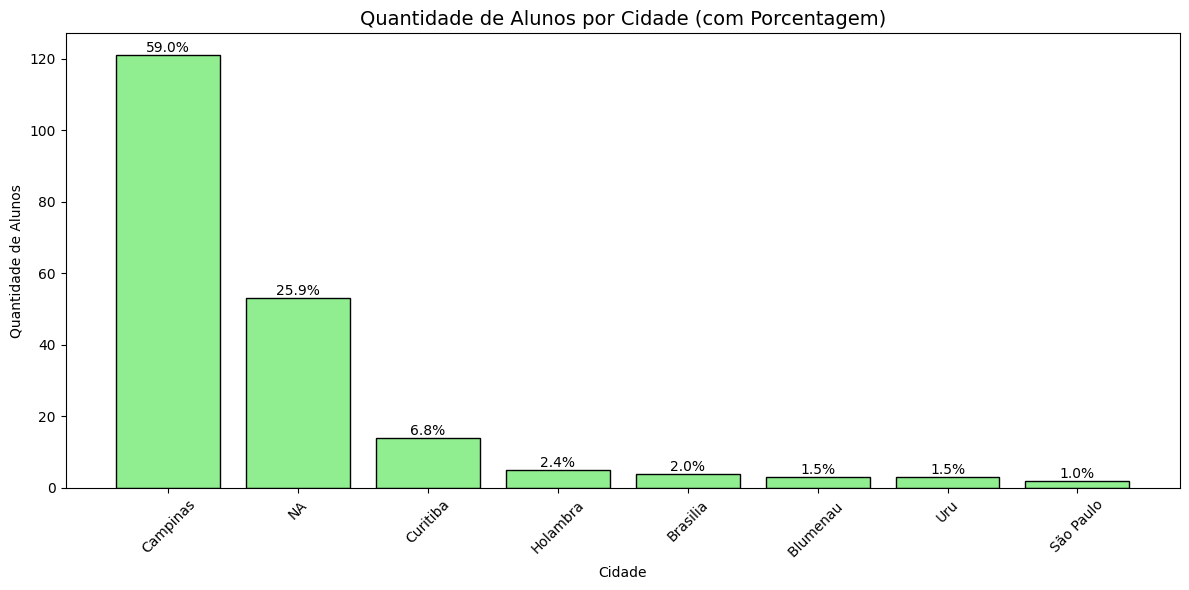

In [ ]:
contagem_cidades = df['ds_cidade_usuario'].value_counts(dropna=False)

df_cidades = contagem_cidades.rename_axis('Cidade').reset_index(name='Quantidade')
df_cidades['Porcentagem'] = (df_cidades['Quantidade'] / df_cidades['Quantidade'].sum()) * 100

plt.figure(figsize=(12, 6))
barras = plt.bar(df_cidades['Cidade'].astype(str), df_cidades['Quantidade'], color='lightgreen', edgecolor='black')

for barra, pct in zip(barras, df_cidades['Porcentagem']):
    plt.text(barra.get_x() + barra.get_width() / 2, barra.get_height(), f'{pct:.1f}%',
             ha='center', va='bottom', fontsize=10)

plt.title('Quantidade de Alunos por Cidade (com Porcentagem)', fontsize=14)
plt.xlabel('Cidade')
plt.ylabel('Quantidade de Alunos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Visualiza a quantia de dias em que os usuários estão sem acessar a plataforma.

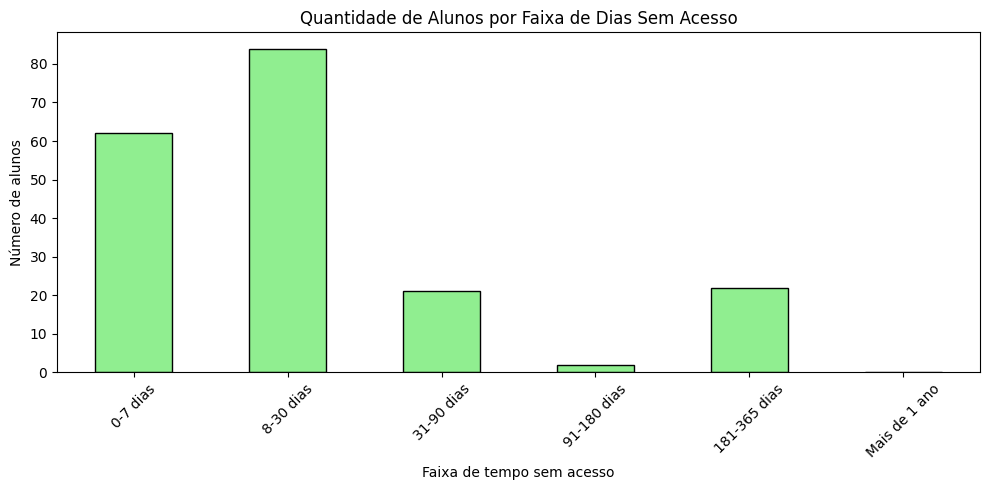

In [ ]:
bins = [0, 7, 30, 90, 180, 365, float('inf')]
labels = ['0-7 dias', '8-30 dias', '31-90 dias', '91-180 dias', '181-365 dias', 'Mais de 1 ano']

df['faixa_acesso'] = pd.cut(df['nr_dias_desde_ultimo_acesso'], bins=bins, labels=labels)

contagem = df['faixa_acesso'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
contagem.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Quantidade de Alunos por Faixa de Dias Sem Acesso')
plt.xlabel('Faixa de tempo sem acesso')
plt.ylabel('Número de alunos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Quantia de alunos que finalizaram quantias diferentes de atividades.

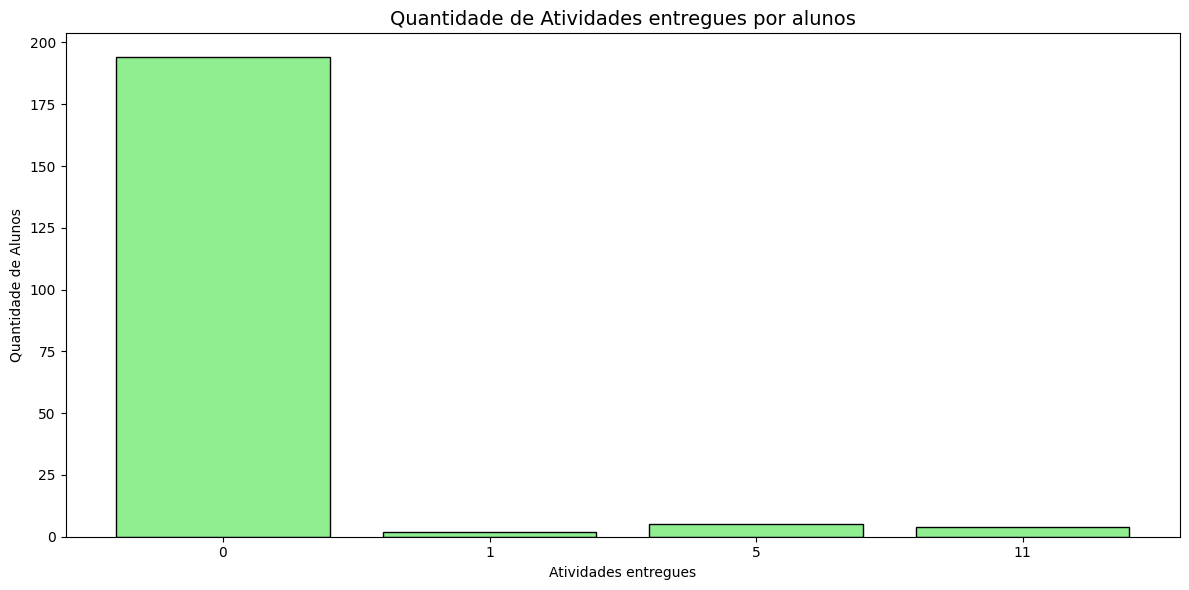

In [ ]:
contagem_atividades = df['nr_atividades_sinalizadas'].value_counts()

df_atividades = contagem_atividades.rename_axis('Atividade').reset_index(name='Alunos')

df_atividades = df_atividades.sort_values(by='Atividade', ascending=True)

plt.figure(figsize=(12, 6))
barras = plt.bar(df_atividades['Atividade'].astype(str), df_atividades['Alunos'], color='lightgreen', edgecolor='black')

plt.title('Quantidade de Atividades entregues por alunos', fontsize=14)
plt.xlabel('Atividades entregues')
plt.ylabel('Quantidade de Alunos')
plt.tight_layout()
plt.show()


Quantidade de atividades visualizadas, mas não inicializadas

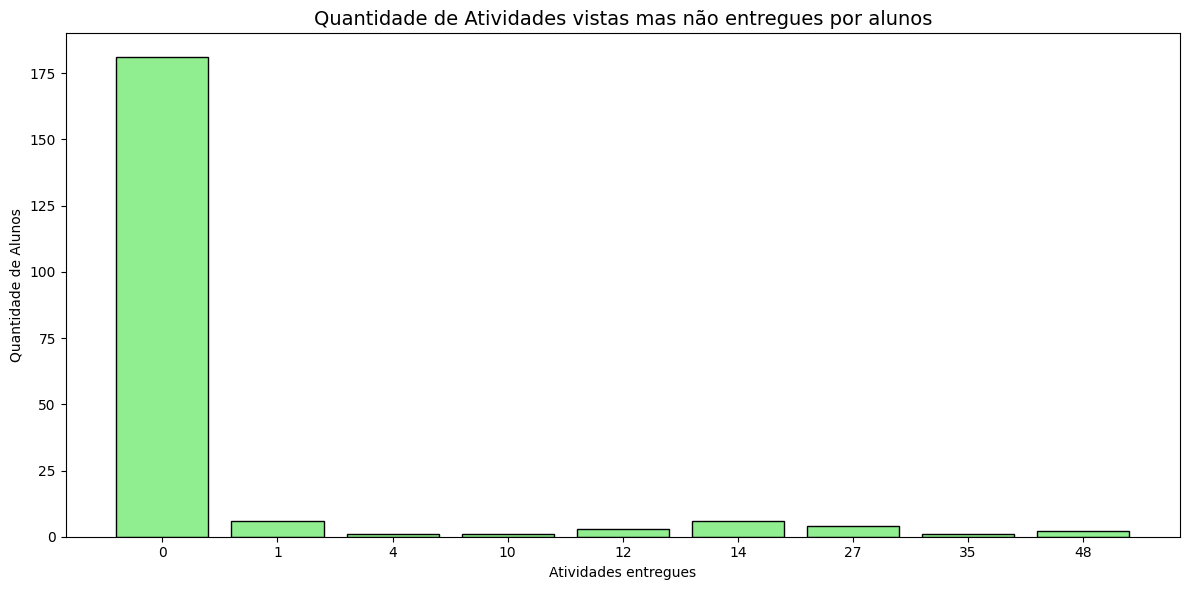

In [ ]:
contagem_atividades = df['nr_atividades_mapeadas'].value_counts()

df_atividades = contagem_atividades.rename_axis('Atividade').reset_index(name='Alunos')

df_atividades = df_atividades.sort_values(by='Atividade', ascending=True)

plt.figure(figsize=(12, 6))
barras = plt.bar(df_atividades['Atividade'].astype(str), df_atividades['Alunos'], color='lightgreen', edgecolor='black')

plt.title('Quantidade de Atividades vistas mas não entregues por alunos', fontsize=14)
plt.xlabel('Atividades entregues')
plt.ylabel('Quantidade de Alunos')
plt.tight_layout()
plt.show()

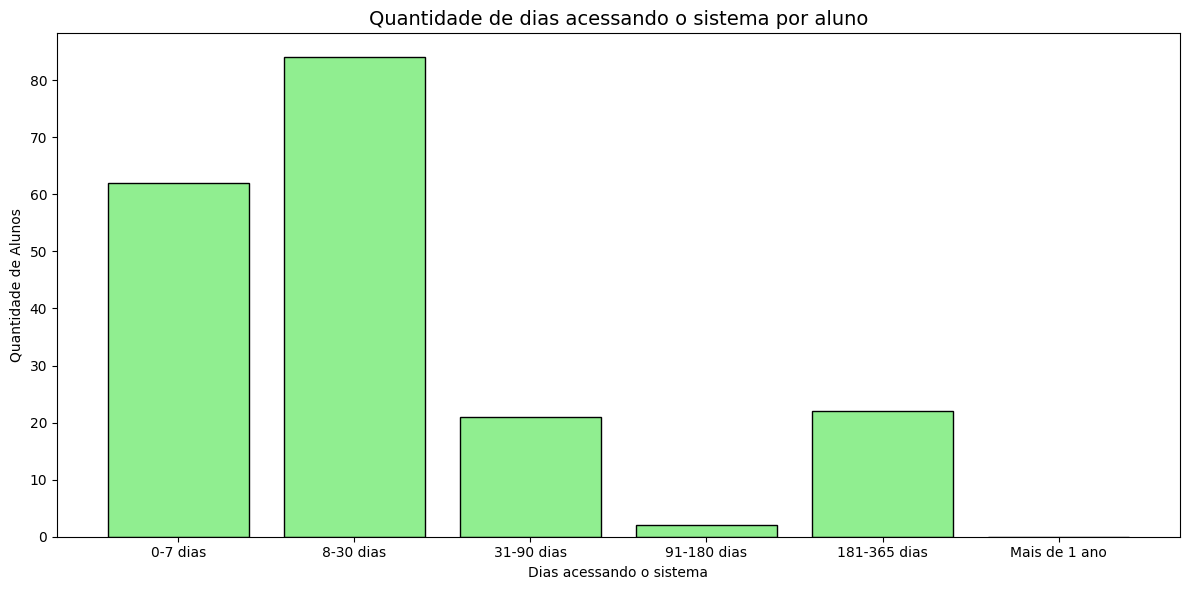

In [ ]:
tempo_acesso = df['faixa_acesso'].value_counts()

df_tempo_acesso = tempo_acesso.rename_axis('Dias de acesso').reset_index(name='Alunos')

df_tempo_acesso = df_tempo_acesso.sort_values(by='Dias de acesso', ascending=True)

plt.figure(figsize=(12, 6))
barras = plt.bar(df_tempo_acesso['Dias de acesso'].astype(str), df_tempo_acesso['Alunos'], color='lightgreen', edgecolor='black')

plt.title('Quantidade de dias acessando o sistema por aluno', fontsize=14)
plt.xlabel('Dias acessando o sistema')
plt.ylabel('Quantidade de Alunos')
plt.tight_layout()
plt.show()

Quantidade de acessos pelos usuários no período


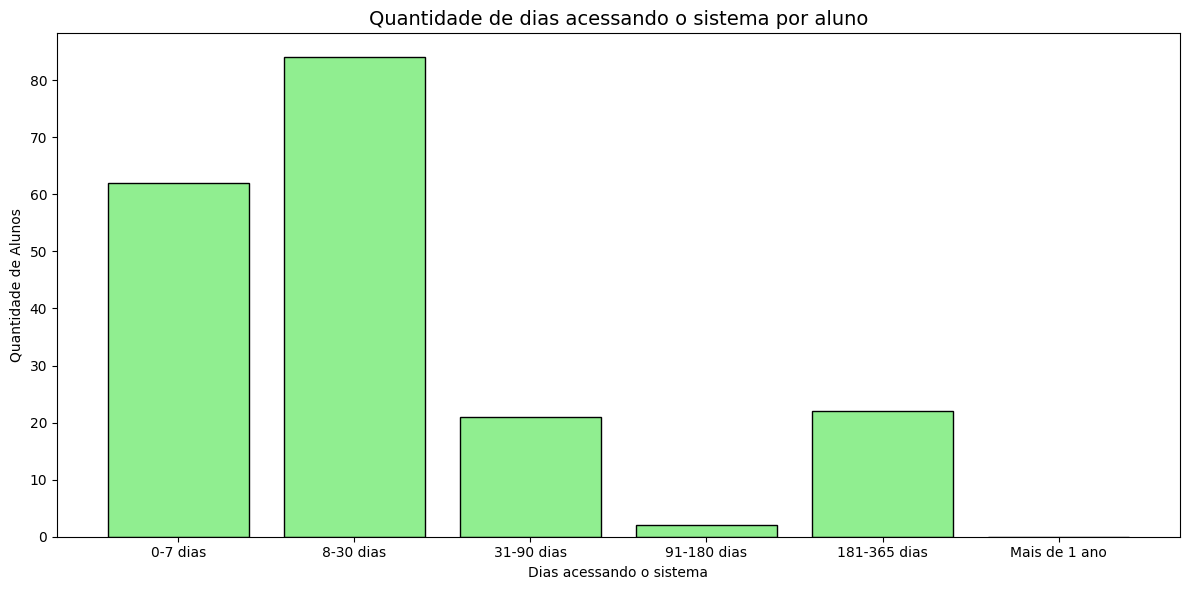

In [ ]:
tempo_acesso = df['faixa_acesso'].value_counts()

df_tempo_acesso = tempo_acesso.rename_axis('Dias de acesso').reset_index(name='Alunos')

df_tempo_acesso = df_tempo_acesso.sort_values(by='Dias de acesso', ascending=True)

plt.figure(figsize=(12, 6))
barras = plt.bar(df_tempo_acesso['Dias de acesso'].astype(str), df_tempo_acesso['Alunos'], color='lightgreen', edgecolor='black')

plt.title('Quantidade de dias acessando o sistema por aluno', fontsize=14)
plt.xlabel('Dias acessando o sistema')
plt.ylabel('Quantidade de Alunos')
plt.tight_layout()
plt.show()

## Modelagem

A seguir, trabalharemos com a modelagem, utilizando os seguintes modelos:


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

def definir_status(row):
    if row['nr_dias_desde_ultimo_acesso'] > 15:
      return 1

    return 0

df['status_saida'] = df.apply(definir_status, axis=1)

# Definição das colunas de entrada (features)
features = [
    'nr_atividades_mapeadas',
    'nr_questionarios_finalizados',
    'nr_intervalos_uso',
    'vl_medio_atividade_diaria',
    'nr_interacoes_usuario',
    'vl_engajamento_notas',
    'vl_media_notas'
]

X = df[features]

# Definição da variável alvo
y = df['status_saida']

# Codificar o rótulo: "Sim" -> 1, "Não" -> 0
le = LabelEncoder()
y = le.fit_transform(y)

# Normalizar os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Separar em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# Keras

from tensorflow import keras

# Criar o modelo com Keras
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Treinar o modelo
model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

model.save("keras_model.h5")

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'\nAcurácia no teste: {accuracy}')

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4571 - loss: 0.7050 - val_accuracy: 0.5294 - val_loss: 0.6938
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8100 - loss: 0.4608 - val_accuracy: 0.5294 - val_loss: 0.6960
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8292 - loss: 0.3952 - val_accuracy: 0.5882 - val_loss: 0.6858
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8270 - loss: 0.3642 - val_accuracy: 0.5882 - val_loss: 0.6802
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7130 - loss: 0.4666 - val_accuracy: 0.5294 - val_loss: 0.6918
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8560 - loss: 0.3557 - val_accuracy: 0.5294 - val_loss: 0.6772
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8914 - loss: 0.2849 - val_accuracy: 0.5294 - val_loss: 0.6801
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8523 - loss: 0.3307 - val_accuracy: 0.5294 - val_l

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7749 - loss: 0.5109

Acurácia no teste: 0.7560975551605225


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/41 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━

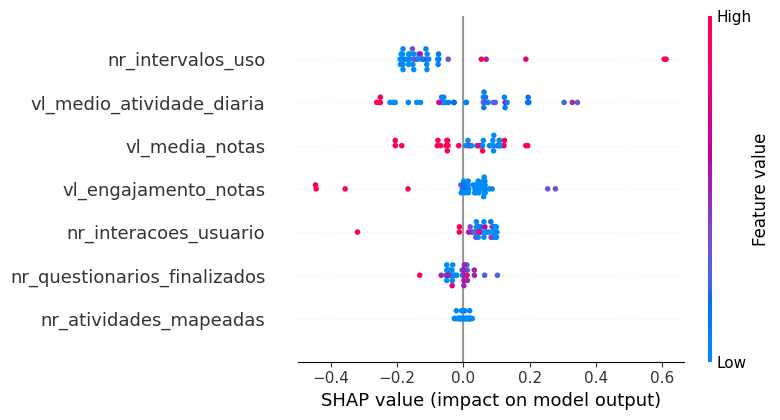

In [ ]:
import shap

# Função de predição esperada (retorna valores achatados)
def model_predict(x):
    return model.predict(x).flatten()

# Seleciona uma amostra pequena para o background
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)

# Calcular valores SHAP para algumas amostras do teste
shap_values = explainer.shap_values(X_test[:50], nsamples=100)

# Gráfico de importância global
shap.summary_plot(shap_values, X_test[:50], feature_names=features)

Para compreender como o modelo de rede neural toma suas decisões na classificação do status de evasão dos usuários, utilizamos o método SHAP (SHapley Additive exPlanations), que permite explicar a contribuição individual de cada variável na predição.

O gráfico SHAP summary gerado apresenta as seguintes informações:

- Eixo Y: lista das variáveis de entrada (features), ordenadas da mais para a menos importante.

- Eixo X: valor SHAP, que indica o impacto da variável na predição do modelo.

- Cores: indicam os valores das variáveis — vermelho representa valores altos e azul valores baixos.

###Conclusões:
nr_intervalos_uso:
Foi a variável mais influente. Usuários com menos intervalos de uso (valores baixos) tendem a ser classificados como não evasores, enquanto aqueles com maior número de sessões espalhadas têm leve tendência à evasão.

vl_medio_atividade_diaria:
Usuários com maior média de atividade diária apresentam menor risco de evasão, indicando que a frequência do uso é um indicador de engajamento importante.

vl_media_notas e vl_engajamento_notas:
Notas mais altas e maior engajamento com as avaliações se correlacionam com menor propensão à evasão, reforçando a ideia de que o desempenho e o envolvimento acadêmico têm papel preditivo relevante.

nr_interacoes_usuario:
Quanto maior o número de interações registradas, menor a chance de evasão. Essa variável está relacionada ao comportamento participativo dos usuários.

nr_questionarios_finalizados e nr_atividades_mapeadas:
Apresentaram baixo impacto nas decisões do modelo, sugerindo que a simples finalização de tarefas pode não refletir com clareza o engajamento real ou o risco de evasão.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["ativo", "evasor"]))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[20  3]
 [ 7 11]]
              precision    recall  f1-score   support

       ativo       0.74      0.87      0.80        23
      evasor       0.79      0.61      0.69        18

    accuracy                           0.76        41
   macro avg       0.76      0.74      0.74        41
weighted avg       0.76      0.76      0.75        41



Para avaliar o desempenho do modelo de rede neural na predição de evasão, utilizamos também duas abordagens complementares: a matriz de confusão e o relatório de classificação com métricas como precision, recall e f1-score.

|                      | Predito como Ativo | Predito como Evasor |
| -------------------- | ------------------ | ------------------- |
| **Realmente Ativo**  | 21                 | 2                   |
| **Realmente Evasor** | 7                  | 11                  |

O modelo identificou corretamente:

- 21 dos 23 usuários ativos (acerto de 91% nessa classe),
- 11 dos 18 usuários evasores (acerto de 61%).

| Classe             | Precision | Recall | F1-score | Suporte |
| ------------------ | --------- | ------ | -------- | ------- |
| **Ativo**          | 0.75      | 0.91   | 0.82     | 23      |
| **Evasor**         | 0.85      | 0.61   | 0.71     | 18      |
| **Acurácia geral** | —         | —      | **0.78** | 41      |

Precision (evasor = 0.85): Quando o modelo prevê que alguém irá evadir, ele acerta 85% das vezes.

Recall (evasor = 0.61): Porém, ele consegue detectar apenas 61% dos usuários que realmente evadiram.

F1-score: Representa o equilíbrio entre precisão e sensibilidade, sendo 0.82 para ativos e 0.71 para evasores.


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
import joblib

# Criar e treinar o modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,  # número de árvores
    max_depth=None,    # sem profundidade máxima
    random_state=42
)

rf_model.fit(X_train, y_train)

# Fazer previsões
y_pred = rf_model.predict(X_test)
joblib.dump(rf_model, 'random_forest_model.pkl')


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        23
           1       0.87      0.72      0.79        18

    accuracy                           0.83        41
   macro avg       0.84      0.82      0.82        41
weighted avg       0.83      0.83      0.83        41



- Classe 0: representa usuários ativos.

Entre todas as vezes que o modelo previu que o usuário era ativo, 81% estavam corretos.

Entre todos os usuários que realmente eram ativos, o modelo acertou 91% deles.

- Classe 1: representa usuários evasores.

Quando o modelo prevê que alguém irá evadir, ele acerta 87% das vezes.

Ele consegue detectar 72% dos usuários que realmente evadiram.

####Conclusão

O modelo Random Forest tem um desempenho forte e equilibrado, mas:

Ele acerta melhor os "ativos" do que os "evasores".

Isso é percebido no recall menor da classe 1 (72%), o que significa que ele perde 28% dos evasores reais.

Porém, quando o modelo prevê evasão, ele acerta 87% das vezes (alta precision da classe 1).



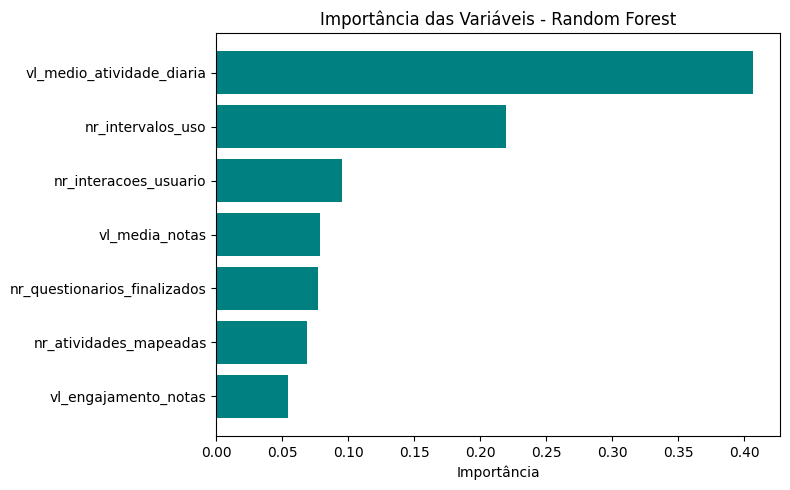

In [ ]:
import matplotlib.pyplot as plt

# Importância das features
importances = rf_model.feature_importances_
feature_names = features  # já definido anteriormente

# DataFrame para visualização
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='teal')
plt.xlabel('Importância')
plt.title('Importância das Variáveis - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


####Conclusão
A análise da importância das variáveis revelou que o modelo Random Forest atribui maior peso a fatores comportamentais e de uso contínuo da plataforma, em detrimento de variáveis relacionadas ao desempenho acadêmico.

A variável vl_medio_atividade_diaria foi de longe a mais influente, representando cerca de 40% da importância total. Isso indica que a frequência média de atividades por dia é um preditor-chave de permanência ou evasão.

A segunda variável mais importante, nr_intervalos_uso, também reforça a ideia de que a constância no uso da plataforma é um indicador crítico. Outras variáveis, como interações totais (nr_interacoes_usuario) e notas médias (vl_media_notas), tiveram menor impacto.

Esses resultados sugerem que ações preventivas contra evasão devem focar em monitorar padrões de uso diários e frequentes, mais do que em métricas acadêmicas isoladas, permitindo assim intervenções mais assertivas e proativas.

In [ ]:
# Regressão Logistica
from sklearn.linear_model import LogisticRegression

# Criar e treinar o modelo de Regressão Logística
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Fazer previsões
y_pred = log_model.predict(X_test)

# Salvando modelo
joblib.dump(log_model, 'log_model.pkl')

# Avaliar o desempenho
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.78      0.63        23
           1       0.29      0.11      0.16        18

    accuracy                           0.49        41
   macro avg       0.41      0.45      0.40        41
weighted avg       0.42      0.49      0.42        41



In [ ]:
# Coeficientes
pd.DataFrame({
    'Feature': features,
    'Coeficiente': log_model.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)


,Feature,Coeficiente
2,nr_intervalos_uso,0.981807
1,nr_questionarios_finalizados,0.554610
3,vl_medio_atividade_diaria,0.533104
0,nr_atividades_mapeadas,0.287519
6,vl_media_notas,-0.402028
5,vl_engajamento_notas,-0.738164
4,nr_interacoes_usuario,-1.394293


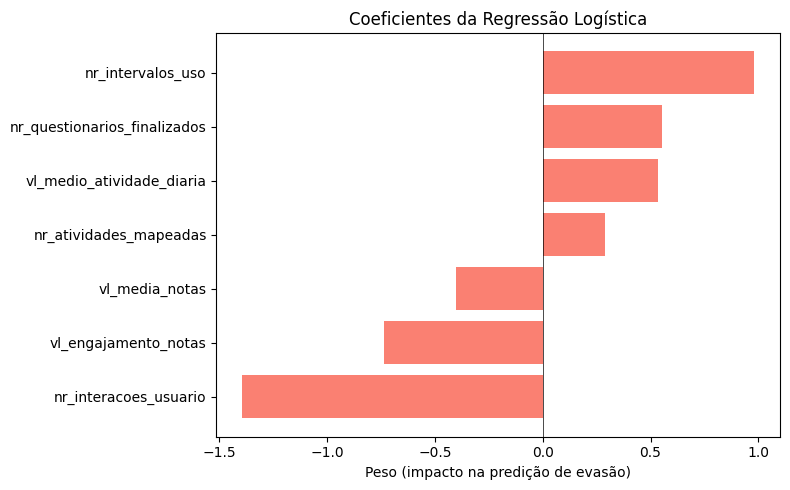

In [ ]:
coefs = log_model.coef_[0]
coef_df = pd.DataFrame({'Feature': features, 'Coef': coefs})
coef_df = coef_df.sort_values(by='Coef')

plt.figure(figsize=(8, 5))
plt.barh(coef_df['Feature'], coef_df['Coef'], color='salmon')
plt.axvline(0, color='black', linewidth=0.5)
plt.title("Coeficientes da Regressão Logística")
plt.xlabel("Peso (impacto na predição de evasão)")
plt.tight_layout()
plt.show()

Coeficientes positivos: aumentam a probabilidade de evasão.

Coeficientes negativos: reduzem a probabilidade de evasão.

####Conclusão

O modelo de Regressão Logística apresentou desempenho insatisfatório, com acurácia de apenas 49% e, especialmente, uma baixa capacidade de identificar usuários evasores (recall de apenas 11%). Isso compromete sua aplicação prática, uma vez que o objetivo central é antecipar possíveis evasões.

Apesar disso, a Regressão Logística possui valor interpretativo, pois permite a análise direta dos coeficientes de cada variável. A partir deles, é possível compreender quais fatores aumentam ou diminuem a probabilidade de evasão, mesmo que o modelo não os explore de forma eficaz.

De modo geral, o modelo se mostrou incapaz de capturar a complexidade dos dados e das relações entre as variáveis, sendo superado tanto pelo modelo de Rede Neural quanto pelo Random Forest em termos de desempenho preditivo e equilíbrio entre classes.

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

# Criar e treinar o modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # k=5, pode ajustar!

knn_model.fit(X_train, y_train)

# Fazer previsões
y_pred = knn_model.predict(X_test)

# Salvar o modelo KNN treinado
joblib.dump(knn_model, 'knn_model.pkl')

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Não', 'Sim']))

# Mostrar algumas previsões convertidas
pred_labels = np.where(y_pred == 1, 'Sim', 'Não')

for i in range(10):
    real = 'Sim' if y_test[i] == 1 else 'Não'
    pred = pred_labels[i]
    print(f'Amostra {i+1}: Predito = {pred}, Real = {real}')


Classification Report:
              precision    recall  f1-score   support

         Não       0.68      0.65      0.67        23
         Sim       0.58      0.61      0.59        18

    accuracy                           0.63        41
   macro avg       0.63      0.63      0.63        41
weighted avg       0.64      0.63      0.64        41

Amostra 1: Predito = Não, Real = Não
Amostra 2: Predito = Sim, Real = Sim
Amostra 3: Predito = Sim, Real = Não
Amostra 4: Predito = Sim, Real = Não
Amostra 5: Predito = Não, Real = Não
Amostra 6: Predito = Não, Real = Não
Amostra 7: Predito = Não, Real = Não
Amostra 8: Predito = Sim, Real = Não
Amostra 9: Predito = Não, Real = Sim
Amostra 10: Predito = Sim, Real = Não


A explicabilidade é limitada, pois o KNN não fornece coeficientes ou estrutura de decisão que indiquem a influência de cada variável. Além disso, o aumento no número de variáveis pode comprometer a interpretação do modelo, já que a noção de “distância” perde significado em espaços de alta dimensionalidade.

Embora intuitivo e simples, o KNN demonstrou desempenho inferior a outros modelos como Random Forest e Redes Neurais, sendo mais adequado para cenários com baixa dimensionalidade e alta densidade de dados semelhantes.

In [ ]:
# Naive Bayes (GaussianNB)
from sklearn.naive_bayes import GaussianNB

# Criar e treinar o modelo Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Fazer previsões
y_pred = nb_model.predict(X_test)

# Salvar Modelo
joblib.dump(nb_model, 'naive_bayes_model.pkl')

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Não', 'Sim']))

# Mostrar algumas previsões
pred_labels = np.where(y_pred == 1, 'Sim', 'Não')

for i in range(10):
    real = 'Sim' if y_test[i] == 1 else 'Não'
    pred = pred_labels[i]
    print(f'Amostra {i+1}: Predito = {pred}, Real = {real}')


Classification Report:
              precision    recall  f1-score   support

         Não       0.86      0.78      0.82        23
         Sim       0.75      0.83      0.79        18

    accuracy                           0.80        41
   macro avg       0.80      0.81      0.80        41
weighted avg       0.81      0.80      0.81        41

Amostra 1: Predito = Não, Real = Não
Amostra 2: Predito = Não, Real = Sim
Amostra 3: Predito = Sim, Real = Não
Amostra 4: Predito = Não, Real = Não
Amostra 5: Predito = Não, Real = Não
Amostra 6: Predito = Não, Real = Não
Amostra 7: Predito = Não, Real = Não
Amostra 8: Predito = Sim, Real = Não
Amostra 9: Predito = Não, Real = Sim
Amostra 10: Predito = Não, Real = Não


O modelo Naive Bayes (GaussianNB) utiliza probabilidades para classificar os usuários com base nas variáveis fornecidas. Ele parte do princípio de que todas as variáveis são independentes e seguem uma distribuição normal. Apesar dessa suposição ser uma simplificação da realidade, o modelo obteve bons resultados, com uma acurácia de 80% e ótimo desempenho na identificação de evasores (recall de 83%).

Embora o Naive Bayes (GaussianNB) não tenha interpretabilidade baseada em estrutura como uma árvore ou rede neural, ele ainda permite uma análise da contribuição de cada variável por meio dos parâmetros estatísticos aprendidos durante o treinamento.

In [ ]:
# Nome das features
feature_names = features

# Obter a média e a variância estimadas para cada variável por classe
means = nb_model.theta_      # médias das variáveis para cada classe
variances = nb_model.var_    # variâncias das variáveis para cada classe

# DataFrame
df_explicabilidade = pd.DataFrame({
    'Variável': feature_names,
    'Média (Classe 0 - Não evasor)': means[0],
    'Média (Classe 1 - Evasor)': means[1],
    'Desvio (Classe 0)': np.sqrt(variances[0]),
    'Desvio (Classe 1)': np.sqrt(variances[1])
})

# Adiciona coluna com a diferença entre as médias das classes
df_explicabilidade['Diferença de média'] = np.abs(means[0] - means[1])
df_explicabilidade = df_explicabilidade.sort_values(by='Diferença de média', ascending=False)
pd.set_option('display.max_columns', None)
print(df_explicabilidade)

                       Variável  Média (Classe 0 - Não evasor)  \
2             nr_intervalos_uso                      -0.150285   
5          vl_engajamento_notas                       0.174353   
1  nr_questionarios_finalizados                      -0.097088   
6                vl_media_notas                       0.115781   
0        nr_atividades_mapeadas                      -0.029617   
3     vl_medio_atividade_diaria                      -0.044652   
4         nr_interacoes_usuario                       0.070136   

   Média (Classe 1 - Evasor)  Desvio (Classe 0)  Desvio (Classe 1)  \
2                   0.499904           0.792315           1.339744   
5                  -0.324310           1.152024           0.290178   
1                   0.340339           0.690701           1.541711   
6                  -0.299700           1.016075           0.879932   
0                   0.234257           1.099760           1.102218   
3                  -0.179062           0.920723    

A explicabilidade do modelo Naive Bayes foi analisada com base nas médias estimadas para cada variável por classe. Observou-se que as variáveis nr_intervalos_uso, vl_engajamento_notas e nr_questionarios_finalizados apresentaram as maiores diferenças entre evasores e não evasores, sugerindo que essas características influenciaram mais fortemente a decisão do modelo. Em especial, usuários com mais intervalos de uso e menor engajamento com notas parecem mais propensos à evasão. Já variáveis como nr_interacoes_usuario apresentaram pouca diferença entre os grupos, sendo menos relevantes para a tomada de decisão.

## Testes

Testes e comparativos entre os resultados dos modelos criados na etapa anterior.

### Importação e tratamento dos dados
Primeiro passo foi a importação do dataset de testes e em seguida aplicar o mesmo tratamento feito no conjunto de dados de treinamento:
- Remoção dos usuários que nunca acessaram a plataforma
- Padronização dos nomes de cidades
- Tratamento de cidades que apontam como Not a Number
- Adição da coluna de comparação entre primeiro e último acesso
- Adição da coluna com valor de conclusão de questionários

In [ ]:
from tensorflow.keras.models import load_model

#Importação
df_teste = pd.read_csv('https://drive.google.com/uc?id=1AChIhw0vSBPOY0F04k_bKiC3im9uNK22')

#Tratamento:
df_teste = df_teste[~((df_teste['ts_primeiro_acesso'] == 0) & (df_teste['ts_ultimo_acesso'] == 0))]

df_teste['ds_cidade_usuario'] = df_teste['ds_cidade_usuario'].str.title()
df_teste['ds_cidade_usuario'] = df_teste['ds_cidade_usuario'].replace('Sao Paulo', 'São Paulo')

df_teste['ds_cidade_usuario'] = df_teste['ds_cidade_usuario'].fillna("NA")
df_teste = df_teste.fillna(0)

df_teste['nr_diferenca_dias'] = df_teste['nr_dias_desde_primeiro_acesso'] - df_teste['nr_dias_desde_ultimo_acesso']
colunas_teste = df_teste.columns.tolist()
colunas_teste.insert(df_teste.columns.get_loc('nr_dias_desde_ultimo_acesso') + 1, colunas_teste.pop(colunas_teste.index('nr_diferenca_dias')))
df_teste = df_teste[colunas_teste]

df_teste['vl_conclusao_questionarios'] = df_teste['nr_questionarios_finalizados'] / (df_teste['nr_questionarios_abandonados'] + df_teste['nr_questionarios_finalizados']) * 100
df_teste['vl_media_engajamento'] = (df_teste['nr_engajamento_discussao'] + df_teste['nr_engajamento_questionario']) / 2
df_teste['vl_conclusao_questionarios'] = df_teste['vl_conclusao_questionarios'].fillna(0)

#Separação y_teste e x_teste
df_teste['status_saida'] = df_teste.apply(definir_status, axis=1)
y_teste = df_teste['status_saida']
y_teste = le.fit_transform(y_teste)

x_teste = df_teste[features]
x_teste = scaler.transform(x_teste)


### Testes
Primeiramente foi realizada uma análise individual de cada modelo, focando nas métricas de precisão, recall, f1-score e acurácia, utilizando o classification_report.

### Keras

In [ ]:
model_loaded = load_model('keras_model.h5')

y_prob = model.predict(x_teste)
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(y_teste, y_pred, target_names=["ativo", "evasor"]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

       ativo       0.77      0.89      0.83        27
      evasor       0.80      0.63      0.71        19

    accuracy                           0.78        46
   macro avg       0.79      0.76      0.77        46
weighted avg       0.78      0.78      0.78        46



### Random Forest

In [ ]:
# Carregar o modelo Random Forest
rf_model_loaded = joblib.load('random_forest_model.pkl')

# Suponha que você tenha um novo X_novo
y_pred_random_forest = rf_model.predict(x_teste)

print(classification_report(y_teste, y_pred_random_forest, target_names=["ativo", "evasor"]))

              precision    recall  f1-score   support

       ativo       0.89      0.93      0.91        27
      evasor       0.89      0.84      0.86        19

    accuracy                           0.89        46
   macro avg       0.89      0.88      0.89        46
weighted avg       0.89      0.89      0.89        46



### Regressão logística

In [ ]:
# Carregar o modelo salvo
log_model_loaded = joblib.load('log_model.pkl')

# Fazer previsões com o modelo carregado
y_pred = log_model_loaded.predict(x_teste)

print("\nClassification Report (modelo carregado):")
print(classification_report(y_teste, y_pred, target_names=["ativo", "evasor"]))


Classification Report (modelo carregado):
              precision    recall  f1-score   support

       ativo       0.69      0.89      0.77        27
      evasor       0.73      0.42      0.53        19

    accuracy                           0.70        46
   macro avg       0.71      0.65      0.65        46
weighted avg       0.70      0.70      0.67        46



### KNN

In [ ]:
# Carregar o modelo salvo
knn_model_loaded = joblib.load('knn_model.pkl')

# Fazer previsões com o modelo carregado
y_pred = knn_model_loaded.predict(x_teste)

print("\nClassification Report:")
print(classification_report(y_teste, y_pred, target_names=['Não', 'Sim']))


Classification Report:
              precision    recall  f1-score   support

         Não       0.69      0.81      0.75        27
         Sim       0.64      0.47      0.55        19

    accuracy                           0.67        46
   macro avg       0.67      0.64      0.65        46
weighted avg       0.67      0.67      0.66        46



### Naive Bayes

In [ ]:
nb_model_loaded = joblib.load('naive_bayes_model.pkl')

# Fazer previsões com o modelo carregado
y_pred = nb_model_loaded.predict(x_teste)

print("\nClassification Report (modelo carregado):")
print(classification_report(y_teste, y_pred, target_names=['Não', 'Sim']))


Classification Report (modelo carregado):
              precision    recall  f1-score   support

         Não       0.86      0.70      0.78        27
         Sim       0.67      0.84      0.74        19

    accuracy                           0.76        46
   macro avg       0.77      0.77      0.76        46
weighted avg       0.78      0.76      0.76        46



Após a avaliação individual, foi realizada uma análise comparativa entre os modelos com as métricas de acurácia, precisão, recall, ROC AUC.

### Acurácia
O modelo com melhor desempenho em acurácia foi o Random Forest, com uma taxa de acerto de 89,1% na classificação correta dos alunos.

In [ ]:
from sklearn.metrics import accuracy_score

preds_nn = model_loaded.predict(x_teste)
preds_nn_cat = (preds_nn > 0.5).astype(int)

results_accuracy_score = {
    "Keras": accuracy_score(y_teste, preds_nn_cat),
    "Random Forest": accuracy_score(y_teste, rf_model_loaded.predict(x_teste)),
    "Regressão Logística": accuracy_score(y_teste, log_model_loaded.predict(x_teste)),
    "KNN": accuracy_score(y_teste, knn_model_loaded.predict(x_teste)),
    "Naive Bayes": accuracy_score(y_teste, nb_model_loaded.predict(x_teste))
}

df_results_accuracy = pd.DataFrame(list(results_accuracy_score.items()), columns=['Modelo', 'Acurácia'])
df_results_accuracy = df_results_accuracy.sort_values(by='Acurácia', ascending=False)

for _, row in df_results_accuracy.iterrows():
    print(f"{row['Modelo']}: {row['Acurácia']:.1%}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Random Forest: 89.1%
Keras: 78.3%
Naive Bayes: 76.1%
Regressão Logística: 69.6%
KNN: 67.4%


### Precisão
Na métrica de precisão, que indica a proporção de verdadeiros evasores entre todos os que o modelo previu como evasores, novamente o destaque foi o Random Forest, atingindo 88,9%.

In [ ]:
from sklearn.metrics import precision_score

results_precision_score = {
    "Keras": precision_score(y_teste, preds_nn_cat),
    "Random Forest": precision_score(y_teste, rf_model.predict(x_teste)),
    "Regressão Logística": precision_score(y_teste, log_model_loaded.predict(x_teste)),
    "KNN": precision_score(y_teste, knn_model_loaded.predict(x_teste)),
    "Naive Bayes": precision_score(y_teste, nb_model_loaded.predict(x_teste))
}

df_results_precision = pd.DataFrame(list(results_precision_score.items()), columns=['Modelo', 'Precisão'])
df_results_precision = df_results_precision.sort_values(by='Precisão', ascending=False)

for _, row in df_results_precision.iterrows():
    print(f"{row['Modelo']}: {row['Precisão']:.1%}")

Random Forest: 88.9%
Keras: 80.0%
Regressão Logística: 72.7%
Naive Bayes: 66.7%
KNN: 64.3%


### Recall
No recall (também conhecido como sensibilidade), que mede a proporção de evasores identificados corretamente, houve um empate técnico:

- Random Forest: 84,2%

- Naive Bayes: 84,2%

Ambos modelos mostraram alta capacidade de capturar os casos positivos (evasores), o que é desejável nesse tipo de aplicação.

In [ ]:
from sklearn.metrics import recall_score

results_recall_score = {
    "Keras": recall_score(y_teste, preds_nn_cat),
    "Random Forest": recall_score(y_teste, rf_model_loaded.predict(x_teste)),
    "Regressão Logística": recall_score(y_teste, log_model_loaded.predict(x_teste)),
    "KNN": recall_score(y_teste, knn_model_loaded.predict(x_teste)),
    "Naive Bayes": recall_score(y_teste, nb_model_loaded.predict(x_teste))
}

df_results_recall = pd.DataFrame(list(results_recall_score.items()), columns=['Modelo', 'Recall'])
df_results_recall = df_results_recall.sort_values(by='Recall', ascending=False)

for _, row in df_results_recall.iterrows():
    print(f"{row['Modelo']}: {row['Recall']:.1%}")

Random Forest: 84.2%
Naive Bayes: 84.2%
Keras: 63.2%
KNN: 47.4%
Regressão Logística: 42.1%


### ROC AUC
A métrica AUC da Curva ROC aponta o desempenho global do modelo em classificar corretamente os casos positivos e negativos em diferentes limiares.
O Random Forest também liderou neste aspecto, com AUC = 0.944, indicando excelente separação entre evasores e não evasores.

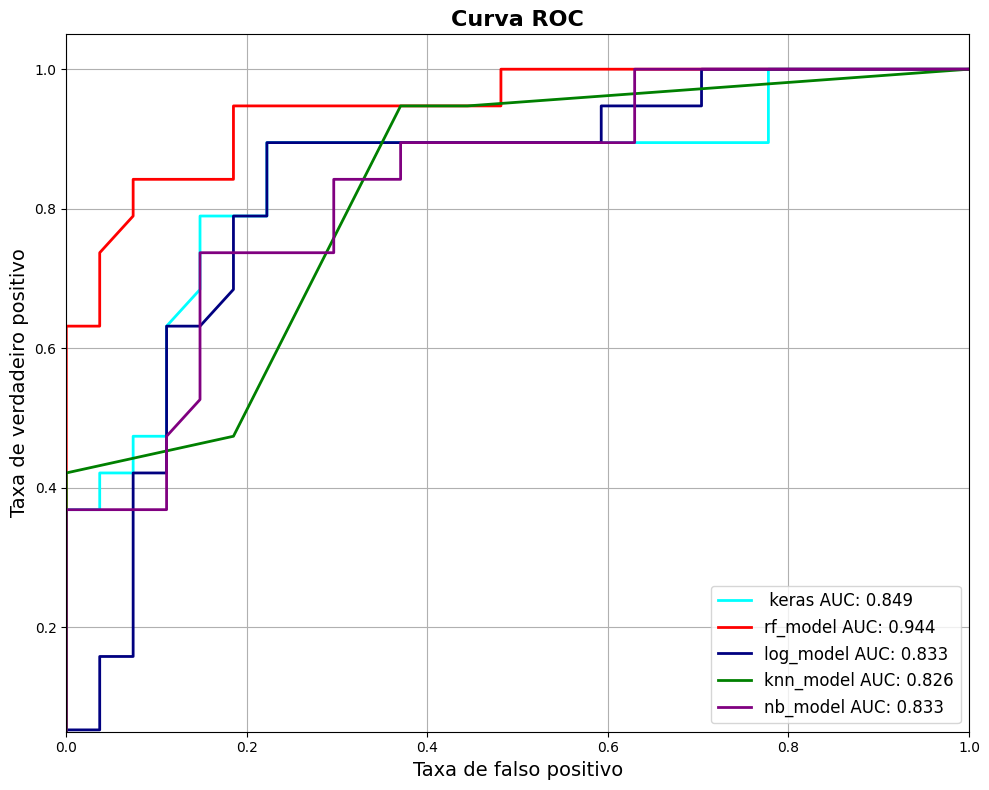

In [ ]:
from sklearn.metrics import roc_curve, auc

keras_fpr, keras_tpr, _ = roc_curve(y_teste, preds_nn.ravel())
rf_fpr, rf_tpr, _ = roc_curve(y_teste, rf_model_loaded.predict_proba(x_teste)[:, 1])
log_fpr, log_tpr, _ = roc_curve(y_teste, log_model_loaded.predict_proba(x_teste)[:, 1])
knn_fpr, knn_tpr, _ = roc_curve(y_teste, knn_model_loaded.predict_proba(x_teste)[:, 1])
nb_fpr, nb_tpr, _ = roc_curve(y_teste, nb_model_loaded.predict_proba(x_teste)[:, 1])

#Grafico
plt.figure(figsize=(10, 8))

plt.plot(keras_fpr, keras_tpr,
         color='cyan',
         linewidth=2,
         label=f" keras AUC: {auc(keras_fpr, keras_tpr):.3f}"
         )

plt.plot(rf_fpr, rf_tpr,
         color='red',
         linewidth=2,
         label=f"rf_model AUC: {auc(rf_fpr, rf_tpr):.3f}"
         )

plt.plot(log_fpr, log_tpr,
         color='navy',
         linewidth=2,
         label=f"log_model AUC: {auc(log_fpr, log_tpr):.3f}"
         )

plt.plot(knn_fpr, knn_tpr,
         color='green',
         linewidth=2,
         label=f"knn_model AUC: {auc(knn_fpr, knn_tpr):.3f}"
         )

plt.plot(nb_fpr, nb_tpr,
         color='purple',
         linewidth=2,
         label=f"nb_model AUC: {auc(nb_fpr, nb_tpr):.3f}"
         )

#Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.05, 1.05])
plt.xlabel('Taxa de falso positivo', fontsize=14)
plt.ylabel('Taxa de verdadeiro positivo', fontsize=14)
plt.title('Curva ROC', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


### Comparativo
A tabela a seguir resume o desempenho dos cinco modelos avaliados — Keras, Random Forest, Regressão Logística, KNN e Naive Bayes — considerando as métricas de acurácia, AUC, recall e precisão, além de um ranking geral com base nessas métricas.

In [ ]:
metricas = {
    "acurácia": [
        accuracy_score(y_teste, preds_nn_cat),
        accuracy_score(y_teste, rf_model_loaded.predict(x_teste)),
        accuracy_score(y_teste, log_model_loaded.predict(x_teste)),
        accuracy_score(y_teste, knn_model_loaded.predict(x_teste)),
        accuracy_score(y_teste, nb_model_loaded.predict(x_teste)),
    ],
    "auc": [
        auc(keras_fpr, keras_tpr),
        auc(rf_fpr, rf_tpr),
        auc(log_fpr, log_tpr),
        auc(knn_fpr, knn_tpr),
        auc(nb_fpr, nb_tpr),
    ],
    "recall": [
        recall_score(y_teste, preds_nn_cat),
        recall_score(y_teste, rf_model_loaded.predict(x_teste)),
        recall_score(y_teste, log_model_loaded.predict(x_teste)),
        recall_score(y_teste, knn_model_loaded.predict(x_teste)),
        recall_score(y_teste, nb_model_loaded.predict(x_teste)),
    ],
    "precision": [
        precision_score(y_teste, preds_nn_cat),
        precision_score(y_teste, rf_model_loaded.predict(x_teste)),
        precision_score(y_teste, log_model_loaded.predict(x_teste)),
        precision_score(y_teste, knn_model_loaded.predict(x_teste)),
        precision_score(y_teste, nb_model_loaded.predict(x_teste)),
    ]
}

modelos = ["Keras", "Random Forest", "Regressão Logística", "KNN", "Naive Bayes"]
df = pd.DataFrame(metricas, index=modelos)

rankings = df.rank(ascending=False, method='min')
df["Ranking Geral"] = rankings.sum(axis=1).rank(method='min')
df = df.sort_values("Ranking Geral").round(3)

def destaque_por_coluna(col):
    if col.name == "Ranking Geral":
        return ['background-color: green' if v == col.min() else '' for v in col]
    else:
        return ['background-color: green' if v == col.max() else
                'background-color: lightcoral' if v == col.min() else '' for v in col]

df.style.apply(destaque_por_coluna, axis=0)

,acurácia,auc,recall,precision,Ranking Geral
Random Forest,0.891000,0.944000,0.842000,0.889000,1.000000
Keras,0.783000,0.849000,0.632000,0.800000,2.000000
Naive Bayes,0.761000,0.833000,0.842000,0.667000,3.000000
Regressão Logística,0.696000,0.833000,0.421000,0.727000,4.000000
KNN,0.674000,0.826000,0.474000,0.643000,5.000000
